In [4]:

import numpy as np
from matplotlib import pyplot as plt
import Functions_data_analysis as fda
import Functions_plotting as fp
import xarray as xr
import xmitgcm
import matplotlib.path as mpath
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
from Datasets import exp_set_dict_warm_order, exp_set_dict_wind_order
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import Functions_data_analysis as fda
import string

In [3]:
# Get SIA data for specified season

# season = 'winter'
season = 'spring'

exp_set = 'ic_2001'
plot_region = 'AS_near'
lat1,lat2,lon1,lon2 = fda.plot_regions[plot_region]

# Get all 60 months of data in all 10 runs
fname = '../Saved Arrays/Ensemble_data/SIarea_'+exp_set+'_full_model_domain_60_months.nc'
try:
    ds = xr.open_dataset(fname)
    sia_da = ds.SIarea
    print(fname, 'found')
except FileNotFoundError:
    sia_da = fda.get_ensemble_data_for_ic('SIarea', runs, 'full_model_domain',  'state_2d_set2', n_months = 60) 
    ds = sia_da.to_dataset(name = 'SIarea')
    ds.to_netcdf(fname)
    print(fname,'not found, saved new .nc file!')

# get ice data
land_ice_ds = fda.get_bathymetry_and_troughs()

# Select region 
sia_da_reg = sia_da.sel(lat = slice(lat1,lat2), lon = slice(lon1,lon2))

# Select seasonal data (in all 5yrs)
seas_dict = {'winter':[6,7,8],
             'spring':[9,10,11],
             'summer':[12,1,2],
             'fall':[3,4,5] }
seas_sia_da = sia_da_reg.sel(time=sia_da_reg['time'].dt.month.isin(seas_dict[season]))

# # Get ensemble mean in season for all 5 years
seas_sia_da_5yr_mean = seas_sia_da.mean(dim='time')
seas_sia_em_5yr = seas_sia_da_5yr_mean.mean(dim='run') #shape (n_lats, n_lons)

# # # Calc anoms in each year relative to 5-year seasonal mean
# seas_sia_da_yr5 = seas_sia_da.isel(time=slice(12,15))
# seas_sia_da_yr5_mean = seas_sia_da_yr5.mean(dim='time') 
# seas_sia_yr5_anom = seas_sia_da_yr5_mean - seas_sia_em_5yr #shape (n_runs, n_lats, n_lons)

# # get warm and cool composites for 5th yr seasonal mean in anomalies rel to yr1 seas mean
# warm_sia_yr5_runs = seas_sia_yr5_anom.isel(run=slice(0,4))
# warm_sia_yr5_anom = warm_sia_yr5_runs.mean(dim='run')
# cool_sia_yr5_runs = seas_sia_yr5_anom.isel(run=slice(4,8))
# cool_sia_yr5_anom = cool_sia_yr5_runs.mean(dim='run')


../Saved Arrays/Ensemble_data/SIarea_ic_2001_full_model_domain_60_months.nc found


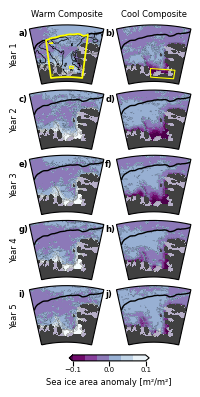

In [12]:
# Plot seasonal Sea ice area anomaly warm and cool composites by year 

sub_labels = list(string.ascii_lowercase[:12])  # ['a', 'b', ..., 'l']

fig = plt.figure()
fig.set_size_inches((2,4))

lons, lats = seas_sia_em_5yr.lon, seas_sia_em_5yr.lat
lat1,lat2,lon1,lon2 = fda.plot_regions['AS_near']
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

axes = []
for i in range(5):

    # calculate year-mean composites
    # select data for this year
    yr_i_data = seas_sia_da.isel(time=slice(i*3,i*3+3))
    # average over this year
    yr_i_data_mean = yr_i_data.mean(dim='time')
    # put in anoms relative to 5-year-ens-mean
    yr_i_anoms = yr_i_data_mean - seas_sia_em_5yr
    
    # get warm and cool composites
    warm_anom_runs = yr_i_anoms.isel(run=slice(0,4))
    warm_anom_yr_i = warm_anom_runs.mean(dim='run')
    cool_anom_runs = yr_i_anoms.isel(run=slice(4,8))
    cool_anom_yr_i = cool_anom_runs.mean(dim='run')
    
    ax = fig.add_subplot(5,2,i*2+1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))
    ax.contourf(lons, lats, warm_anom_yr_i, levels = np.linspace(-.1,.1,7),
                     transform=grid_proj, cmap='BuPu_r', extend='both')
    ax.contour(lons,lats,warm_anom_yr_i,np.linspace(-0.1,0.1,7),colors='k',transform=grid_proj,linewidths=0.1,zorder=1)
    ax.text(-0.2, 0.5, 'Year '+str(i+1),transform=ax.transAxes, fontsize=6, rotation=90,
            va='center', ha='center')
    if i == 0:
        ax.set_title('Warm Composite', fontsize=6)
    axes.append(ax)

    ax = fig.add_subplot(5,2,i*2+2,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))
    cf = ax.contourf(lons, lats, cool_anom_yr_i, levels = np.linspace(-.1,.1,7),
                     transform=grid_proj, cmap='BuPu_r', extend='both')
    ax.contour(lons,lats,cool_anom_yr_i,np.linspace(-.1,.1,7),colors='k',transform=grid_proj,linewidths=0.1,zorder=1)
    if i == 0:
        ax.set_title('Cool Composite', fontsize=6)
    axes.append(ax)
        
for i, ax in enumerate(axes):
    # Plot bathyemtry and ice and plot
    land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    lons,lats = land_ice_ds.lon, land_ice_ds.lat
    blevs = (1500,)
    ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=1,zorder=1)
    if ax == axes[0]:
        ax.contour(lons,lats,land_ice_ds.bathy,(500,1500,),colors='k',transform=grid_proj,linewidths=0.5,zorder=1)
    ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
    ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

    # Set shape of map to match shape of data rather than a rectangle
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

    label = f"{sub_labels[i]})"
    ax.text(-0.15, 0.93, label, transform=ax.transAxes,
            fontsize=6, fontweight='bold', va='top', ha='left')

# Add colorbar
cb_ax1 = fig.add_axes([0.32,0.08,0.4,0.015])
cb1 = fig.colorbar(cf, cax=cb_ax1, extend='both',orientation = 'horizontal')  
cb1.set_label(label = 'Sea ice area anomaly [m²/m²]', fontsize=6)
cb1.ax.tick_params(labelsize=5,pad=0.5)
cb1.set_ticks([-0.1,0,0.1])

# Add analysis regions to first subplot
color = 'yellow'
boxes = ['COT','PITT']
lons_og, lats_og = sia_da.lon,sia_da.lat
for box in boxes:
    lat_i1,lat_i2,lon_i1,lon_i2 = fda.trough_idx_dict[box]
    lon1, lon2 = lons_og.isel(lon=lon_i1), lons_og.isel(lon=lon_i2)
    lat1, lat2 = lats_og.isel(lat=lat_i1), lats_og.isel(lat=lat_i2)
    box = mpatches.Rectangle((lon1, lat1), lon2 - lon1, lat2 - lat1, edgecolor=color, 
                         fill=False, linewidth=0.8,transform=ccrs.PlateCarree())
    axes[0].add_patch(box)

# plot ice shelf box
lat_1,lat_2,lon_1,lon_2 = fda.analysis_region_dict['inner_shelf_corner']
lon1, lon2 = lons_og.sel(lon=lon_1,method='nearest'), lons_og.sel(lon=lon_2,method='nearest')
lat1, lat2 = lats_og.sel(lat=lat_1,method='nearest'), lats_og.sel(lat=lat_2,method='nearest')
box = mpatches.Rectangle((lon1, lat1), lon2 - lon1, lat2 - lat1, edgecolor=color, 
                         fill=False, linewidth=0.8,transform=ccrs.PlateCarree(),zorder=3)
axes[1].add_patch(box)

#plot total shelf box
# create mask where shelf-break is found using 1750m isobath
s_lat1,s_lat2,s_lon1,s_lon2 = fda.analysis_region_dict['naughten_shelf_box'] #start with box defined
shelf_box_ds = land_ice_ds.sel(lat = slice(s_lat1,s_lat2),lon=slice(s_lon1,s_lon2))
#create mask in box everywhere shallower than 1750 contour (checked in Find_shelf_break_location.ipynb)
shelf_mask = shelf_box_ds['bathy'] < 1750 
# add shelf-mask to mask spanning plot domain 
shelf_mask_plot_domain =  xr.DataArray(np.full((len(lats), len(lons)), False, dtype=bool),
                                 dims=('lat', 'lon'),
                                 coords={'lat': lats, 'lon': lons})
shelf_lat1_idx = np.where(lats == shelf_mask.lat[0])[0][0]
shelf_lon1_idx = np.where(lons == shelf_mask.lon[0])[0][0]
shelf_n_lats, shelf_n_lons = shelf_mask.shape
# shelf_lat1_idx, shelf_lon1_idx
shelf_mask_plot_domain[shelf_lat1_idx:shelf_lat1_idx+shelf_n_lats,\
                       shelf_lon1_idx:shelf_lon1_idx+shelf_n_lons] = shelf_mask
axes[0].contour(lons,lats, shelf_mask_plot_domain, transform = grid_proj,levels=[0.5],
                colors=color, linewidths=1.25,zorder=3) 
    


fig.subplots_adjust(left=0.1,right=0.95,top=0.92,bottom=0.12,wspace=0.05,hspace=.1)

plt.savefig('Plots/Figure_ED_2.jpg',dpi=800)